In [37]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import lightgbm

from scripts import fe_scripts as fe
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Options
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Engineering on each dataset

## Prepare and store engineered datasets

In [2]:
# Bureau and bureau balance
df_bureau = fe.bureau_and_balance()
df_bureau.to_pickle('../data/data_outputs/feature_engineered/bureau.pkl')
df_bureau.shape

(305811, 84)

In [3]:
# Previous applications
df_previous = fe.previous_applications()
df_previous.to_pickle('../data/data_outputs/feature_engineered/previous.pkl')
df_previous.shape

(338857, 157)

In [4]:
# POS_CASH_balance
df_pos = fe.pos_cash()
df_pos.to_pickle('../data/data_outputs/feature_engineered/pos.pkl')
df_pos.shape

(337252, 18)

In [5]:
# Installments
df_install = fe.installments_payments()
df_install.to_pickle('../data/data_outputs/feature_engineered/installments.pkl')
df_install.shape

(339587, 22)

In [6]:
# Credit card balance
df_ccb = fe.credit_card_balance()
df_ccb.to_pickle('../data/data_outputs/feature_engineered/credit_card.pkl')
df_ccb.shape

(103558, 113)

## Merging all dataframes

In [ ]:
# Main dataset
df_app = pd.read_pickle('../data/data_outputs/feature_engineered/application.pkl')
df_app = df_app[~df_app['TARGET'].isna()].drop(columns = ['source'])
df_app.shape

In [ ]:
# Merge bureau
df_ = df_app.join(df_bureau, how = 'left', on = 'SK_ID_CURR')

del df_app
del df_bureau
gc.collect()

In [ ]:
# Merge Previous applications
df_ = df_.join(df_previous, how = 'left', on = 'SK_ID_CURR')
del df_previous
gc.collect()

In [ ]:
# Merge POS_CASH_balance
df_ = df_.join(df_pos, how = 'left', on = 'SK_ID_CURR')
del df_pos
gc.collect()

In [ ]:
# Merge installments
df_ = df_.join(df_install, how = 'left', on = 'SK_ID_CURR')
del df_install
gc.collect()

In [ ]:
# Merge Credit card balance
df_ = df_.join(df_ccb, how = 'left', on = 'SK_ID_CURR')
del df_ccb
gc.collect()

In [ ]:
df_.shape

## Storing dataset

In [14]:
df_.to_pickle('../data/data_outputs/feature_engineered/full_dataset.pkl')

# Feature Selection

https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection/notebook

In [2]:
data = pd.read_pickle('../data/data_outputs/feature_engineered/full_dataset.pkl')

## Searching and dropping columns high correlations

In [3]:
# Correlation matrix
corr = data.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE_0,OCCUPATION_TYPE_1,OCCUPATION_TYPE_2,OCCUPATION_TYPE_3,OCCUPATION_TYPE_4,OCCUPATION_TYPE_5,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE_0,ORGANIZATION_TYPE_1,ORGANIZATION_TYPE_2,ORGANIZATION_TYPE_3,ORGANIZATION_TYPE_4,ORGANIZATION_TYPE_5,ORGANIZATION_TYPE_6,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,...,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRAC

In [4]:
# Number and proportion of columns with high correlations 
l_drop = [c for c in upper.columns if any(upper[c]>0.9)]
len(l_drop), len(l_drop)/len(upper)

(151, 0.2563667232597623)

In [5]:
data = data.drop(columns = l_drop)

In [6]:
del corr, upper

## Handling missing values

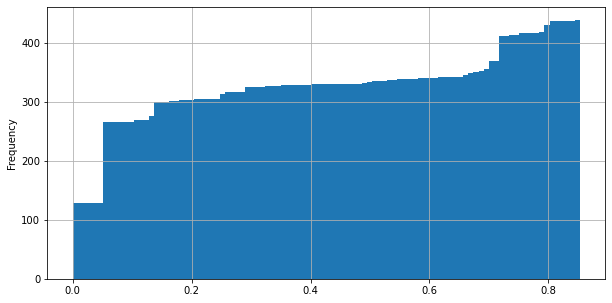

In [8]:
# Proportion of missing values
s_ = data.isnull().sum()/len(data)
s_.plot(kind = 'hist', bins = 100, figsize = (10,5), cumulative = True)
plt.grid()
plt.show()

In [9]:
len(s_[s_>0.75]), len(s_[s_>0.75])/len(s_)

(25, 0.05694760820045558)

In [10]:
# Dropping columns where more than 75% of values are missing
l_drop = [x for x in s_[s_>0.75].index]
data = data.drop(columns = l_drop)
data.shape

del s_, l_drop

## Feature importance

In [46]:
data_sample = data.sample(50000).drop(columns = ['SK_ID_CURR', 'source'])
X_ = data_sample.drop(columns = ['TARGET']).values
y_ = data_sample['TARGET'].values

feature_importances = np.zeros(X_.shape[1])

# LightGBM model
model = lightgbm.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 1000, class_weight = 'balanced')

# Train the model several times and retrieve mean feature importances
for i in range(2):
    x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.35, random_state = i)
    model.fit(x_train, y_train, 
              early_stopping_rounds = 100, 
              eval_set = [(x_test, y_test)],
              eval_metric = 'auc',
              verbose = 200
             )
    feature_importances += model.feature_importances_
    
# Mean of feature_importances
feature_importances = feature_importances/2

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.756139	valid_0's binary_logloss: 0.472212
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.766549	valid_0's binary_logloss: 0.439726


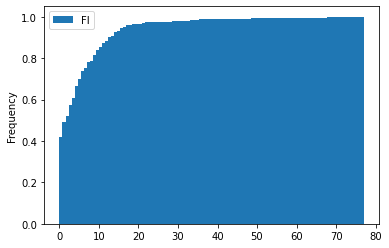

In [47]:
# Feature importance per feature
df_fi = pd.DataFrame(feature_importances,index = data_sample.drop(columns = ['TARGET']).columns, columns = ['FI'])
df_fi.plot(kind = 'hist', cumulative = True, density = True, bins = 100)
plt.show()

In [48]:
# Features with a null importance
l_drop = list(df_fi[df_fi['FI']==0].index)
len(l_drop), len(l_drop)/data.shape[1]

(139, 0.3357487922705314)

In [51]:
# Dropping columns with a null feature importance
data = data.drop(columns = l_drop)
data.shape

(307507, 275)

# Storing cleaned dataset

In [52]:
data.to_pickle('../data/data_outputs/feature_engineered/cleaned_dataset.pkl')